<a href="https://colab.research.google.com/github/mariamlaagrini/Robo-advisor-using-goal-based-investing/blob/main/Robo-advisor_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyPortfolioOpt==1.5.2

In [ ]:
!pip install yfinance
import yfinance as yf

In [ ]:
if __name__ == "__main__":
    print("Welcome to the Robo-Advisor!")
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
import yfinance as yf
from datetime import date
class RiskQuestion:
  def __init__(self, questionText, weight=1):
    self.questionText = questionText
    self.weight = weight
    self.answers = []

class RiskQuestionAnswer:
  def __init__(self, answerText, score, selected=False):
    self.answerText = answerText
    self.score = score
    self.selected = selected

class RiskQuestionnaire:
  def __init__(self):
    self.questions = []
    self.score = 0

  def loadQuestionnaire(self, riskQuestionsFileName, riskAnswersFileName, type):

    if not (type in ["Tolerance", "Capacity"]):
            raise ValueError('Type must be Tolerance or Capacity.')

    import pandas as pd
    riskQuestions = pd.read_csv(riskQuestionsFileName).reset_index()
    riskAnswers = pd.read_csv(riskAnswersFileName).reset_index()

    if (type == "Tolerance"):
      toleranceQuestions = riskQuestions[(riskQuestions['QuestionType'] == 'Tolerance')].reset_index()
      for index, row in toleranceQuestions.iterrows():
          self.questions.append(RiskQuestion(row['QuestionText'], row['QuestionWeight']))
          answers = riskAnswers[(riskAnswers['QuestionID'] == row['QuestionID'])]
          for indexA, rowA in answers.iterrows():
                self.questions[index].answers.append(RiskQuestionAnswer(rowA['AnswerText'],rowA['AnswerValue']))
    else:
      capacityQuestions = riskQuestions[(riskQuestions['QuestionType'] == 'Capacity')].reset_index()
      for index, row in capacityQuestions.iterrows():
          self.questions.append(RiskQuestion(row['QuestionText'], row['QuestionWeight']))
          answers = riskAnswers[(riskAnswers['QuestionID'] == row['QuestionID'])]
          for indexA, rowA in answers.iterrows():
                self.questions[index].answers.append(RiskQuestionAnswer(rowA['AnswerText'],rowA['AnswerValue']))


  def answerQuestionnaire(self):
    for i in range(len(self.questions)):
      question = self.questions[i]
      print(question.questionText)
      for n in range(len(question.answers)):
        answer = question.answers[n]
        print(str(n) + ": " + answer.answerText)
      nChosen = int(input("Choose your answer between 0 and " + str(len(question.answers)-1) + ": "))
      self.questions[i].answers[nChosen].selected = True
      print("\n")

  def calculateScore(self):
    print("Risk Score:")
    myTotalScore = 0
    for question in self.questions:
      for answer in question.answers:
        if (answer.selected == True):
          myTotalScore = myTotalScore + (answer.score * question.weight)
          print(answer.answerText + ": " + str(answer.score * question.weight))
    print("Total Risk Score: " + str(myTotalScore) + "\n")
    self.score = myTotalScore

class Allocation:
  def __init__(self, ticker, percentage):
    self.ticker = ticker
    self.percentage = percentage

class Portfolio:

  def __init__(self, tickerString: str, expectedReturn: float, portfolioName: str, riskBucket: int):

    self.name = portfolioName
    self.riskBucket = riskBucket
    self.expectedReturn = expectedReturn
    self.allocations = []

    from pypfopt.efficient_frontier import EfficientFrontier
    from pypfopt import risk_models
    from pypfopt import expected_returns

    df = self.__getDailyPrices(tickerString, "10y")
    if df.empty:
            raise ValueError("No valid price data available for calculations.")

    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)
    max_return = mu.max()
    if expectedReturn > max_return:
            raise ValueError(f"Target return {expectedReturn} exceeds maximum achievable return {max_return}.")

    ef = EfficientFrontier(mu, S)
    try:
        ef.efficient_return(expectedReturn)
    except ValueError as e:
       raise ValueError(f"Failed to calculate portfolio: {e}")

    self.expectedRisk = ef.portfolio_performance()[1]
    portfolioWeights = ef.clean_weights()

    for key, value in portfolioWeights.items():
      newAllocation = Allocation(key, value)
      self.allocations.append(newAllocation)

  def __getDailyPrices(self, tickerStringList, period):
    data = yf.download(tickerStringList, group_by="Ticker", period=period)
    data = data.iloc[:, data.columns.get_level_values(1)=="Close"]
    data = data.dropna()
    data.columns = data.columns.droplevel(1)
    return data

  def printPortfolio(self):
    print("Portfolio Name: " + self.name)
    print("Risk Bucket: " + str(self.riskBucket))
    print("Expected Return: " + str(self.expectedReturn))
    print("Expected Risk: " + str(self.expectedRisk))
    print("Allocations: ")
    for allocation in self.allocations:
      print("Ticker: " + allocation.ticker + ", Percentage: " + str(allocation.percentage))

  @staticmethod
  def getPortfolioMapping(riskToleranceScore, riskCapacityScore):
    import pandas as pd
    allocationLookupTable=pd.read_csv('Risk Mapping Lookup.csv')
    matchTol = (allocationLookupTable['Tolerance_min'] <= riskTolScore) & (allocationLookupTable['Tolerance_max'] >= riskTolScore)
    matchCap = (allocationLookupTable['Capacity_min'] <= riskCapScore) & (allocationLookupTable['Capacity_max'] >= riskCapScore)
    portfolioID = allocationLookupTable['Portfolio'][(matchTol & matchCap)]
    return portfolioID.values[0]

class Projection:
    def __init__(self, expectedReturn: float, expectedRisk: float, initialInvestment: float, monthlyInvestment: float, years: int):
        df = pd.DataFrame(columns=['date', 'lowValue', 'value', 'highValue'])

        for year in range(years + 1):
            newValue = self.returnProjection(expectedReturn, initialInvestment, monthlyInvestment, year)
            newValueLower = self.returnProjection(expectedReturn - expectedRisk, initialInvestment, monthlyInvestment, year)
            newValueUpper = self.returnProjection(expectedReturn + expectedRisk, initialInvestment, monthlyInvestment, year)
            newDate = date.today().replace(year=date.today().year + year)
            df = pd.concat([df, pd.DataFrame({'date': [newDate], 'lowValue': [newValueLower], 'value': [newValue], 'highValue': [newValueUpper]})])

        df = df.set_index(pd.DatetimeIndex(df['date']))
        self.data = df.drop(columns="date")

    @staticmethod
    def returnProjection(expectedReturn, initialInvestment, monthlyInvestment, years):
        valuePrincipal = initialInvestment * pow(1 + expectedReturn / 12, (years * 12))
        valueMonthly = monthlyInvestment * (pow(1 + expectedReturn / 12, (years * 12)) - 1) / (expectedReturn / 12)
        return valuePrincipal + valueMonthly

    def visualize(self, targetAmount: float = 0.0):
        fig, ax = plt.subplots()
        ax.plot(self.data.index, self.data['highValue'], label="High")
        ax.plot(self.data.index, self.data['value'], label="Expected")
        ax.plot(self.data.index, self.data['lowValue'], label="Low")
        ax.set_ylabel('Portfolio Value (USD)')
        plt.legend(loc="upper left")
        if targetAmount > 0:
            plt.axhline(y=targetAmount, color='r', linestyle='--', label="Target")
            plt.legend()
        plt.show()

class Goal:
  def __init__(self, name, targetYear, targetValue, initialContribution=0, monthlyContribution=0, priority=""):
    self.name = name
    self.targetYear = targetYear
    self.targetValue = targetValue
    self.initialContribution = initialContribution
    self.monthlyContribution = monthlyContribution
    if not (priority == "") and not (priority in ["Dreams", "Wishes", "Wants", "Needs"]):
            raise ValueError('Wrong value set for Priority.')
    self.priority = priority

  def getGoalProbabilities(self):
    if (self.priority == ""):
            raise ValueError('No value set for Priority.')
    import pandas as pd
    lookupTable=pd.read_csv('Goal Probability Table.csv')
    match = (lookupTable['Realize'] == self.priority)
    minProb = lookupTable['MinP'][(match)]
    maxProb = lookupTable['MaxP'][(match)]
    return minProb.values[0], maxProb.values[0]
  def goalProbabilityForAmount(goalAmount, expectedReturn, portfolioRisk, years, initialInvestment, monthlyInvestment) -> float:
   import scipy.stats as st
   import math as math
   std = portfolioRisk/math.sqrt(years)
   amount = 0
   minReturn = 0.00
   while (amount < goalAmount):
    minReturn = minReturn + 0.0000001
    amount = Projection.returnProjection(minReturn, initialInvestment, monthlyInvestment, years)
    z_score = (minReturn-expectedReturn)/std
    return 1-st.norm.cdf(z_score)

Welcome to the Robo-Advisor!


In [ ]:
# Define portfolios for different risk buckets
portfolio1 = Portfolio("SPY TLT AAPL AMZN NFLX GOOGL MSFT", expectedReturn=0.03, portfolioName="Conservative", riskBucket=1)
portfolio2 = Portfolio("SPY TLT AAPL AMZN NFLX GOOGL MSFT", expectedReturn=0.04, portfolioName="Moderate Conservative", riskBucket=2)
portfolio3 = Portfolio("SPY TLT AAPL AMZN NFLX GOOGL MSFT", expectedReturn=0.06, portfolioName="Balanced", riskBucket=3)
portfolio4 = Portfolio("SPY TLT AAPL AMZN NFLX GOOGL MSFT", expectedReturn=0.08, portfolioName="Growth", riskBucket=4)
portfolio5 = Portfolio("SPY TLT AAPL AMZN NFLX GOOGL MSFT", expectedReturn=0.10, portfolioName="Aggressive Growth", riskBucket=5)

# Print portfolio details for each risk bucket
print("\n--- Portfolio Recommendations ---\n")
portfolio1.printPortfolio()
print("\n")
portfolio2.printPortfolio()
print("\n")
portfolio3.printPortfolio()
print("\n")
portfolio4.printPortfolio()
print("\n")
portfolio5.printPortfolio()


[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed


--- Portfolio Recommendations ---

Portfolio Name: Conservative
Risk Bucket: 1
Expected Return: 0.03
Expected Risk: 0.10303445688568723
Allocations: 
Ticker: GOOGL, Percentage: 0.0
Ticker: AAPL, Percentage: 0.0
Ticker: AMZN, Percentage: 0.0
Ticker: NFLX, Percentage: 0.0
Ticker: SPY, Percentage: 0.44178
Ticker: TLT, Percentage: 0.55822
Ticker: MSFT, Percentage: 0.0


Portfolio Name: Moderate Conservative
Risk Bucket: 2
Expected Return: 0.04
Expected Risk: 0.10303451158497859
Allocations: 
Ticker: AAPL, Percentage: 0.0
Ticker: GOOGL, Percentage: 0.0
Ticker: NFLX, Percentage: 0.0
Ticker: AMZN, Percentage: 0.0
Ticker: SPY, Percentage: 0.44178
Ticker: MSFT, Percentage: 0.0
Ticker: TLT, Percentage: 0.55822


Portfolio Name: Balanced
Risk Bucket: 3
Expected Return: 0.06
Expected Risk: 0.10452632810755064
Allocations: 
Ticker: GOOGL, Percentage: 0.0
Ticker: AAPL, Percentage: 0.0
Ticker: NFLX, Percentage: 0.00702
Ticker: AMZN, Percentage: 0.00298
Ticker: TLT, Percentage: 0.50012
Ticker: SPY, P

[*********************100%***********************]  7 of 7 completed


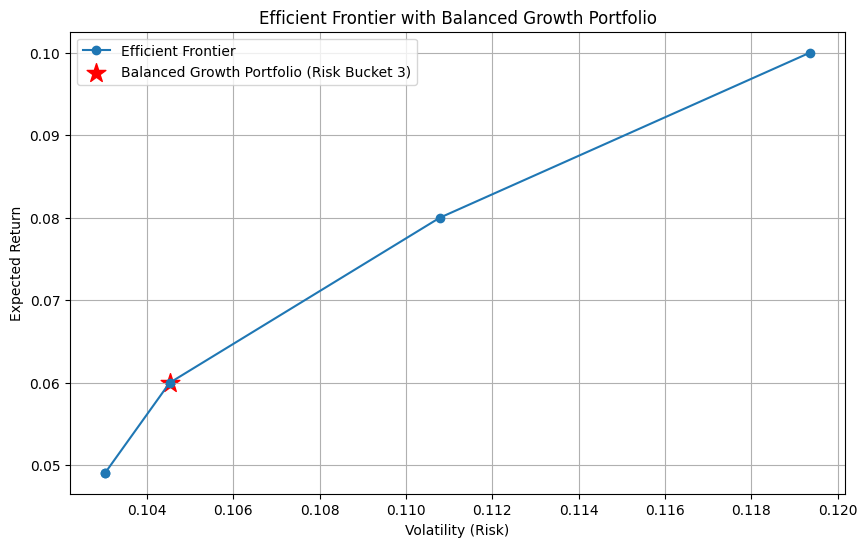

In [ ]:
#Efficient Frontier with Balanced Growth Portfolio
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt.discrete_allocation import get_latest_prices

tickers = "SPY TLT AAPL AMZN NFLX GOOGL MSFT"
#Get data for plotting the Efficient Frontier
df = portfolio5._Portfolio__getDailyPrices(tickers, "10y")
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)
ef = EfficientFrontier(mu, S)

# Generate points for the Efficient Frontier
risk_free_rate = 0.02  # Example risk-free rate
returns = []
risks = []

for target_return in [0.02, 0.04, 0.06, 0.08, 0.10]:
    ef.efficient_return(target_return)
    ret, vol, _ = ef.portfolio_performance()
    returns.append(ret)
    risks.append(vol)

# Step 4: Visualize the Efficient Frontier
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(risks, returns, marker='o', label="Efficient Frontier")

# Highlight Balanced Growth Portfolio
plt.scatter(portfolio3.expectedRisk, portfolio3.expectedReturn, marker="*", color="red", s=200, label="Balanced Growth Portfolio (Risk Bucket 3)")

plt.title("Efficient Frontier with Balanced Growth Portfolio")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.legend(loc="upper left")
plt.grid()
plt.show()

In [ ]:
#Risk questionnaire
print("\nStep 1: Complete the Risk Questionnaire")
questionsFileName = 'Risk Questions.csv'
answersFileName = 'Risk Answers.csv'

toleranceQuestionnaire = RiskQuestionnaire()
toleranceQuestionnaire.loadQuestionnaire(questionsFileName, answersFileName, "Tolerance")

capacityQuestionnaire = RiskQuestionnaire()
capacityQuestionnaire.loadQuestionnaire(questionsFileName, answersFileName, "Capacity")

toleranceQuestionnaire.answerQuestionnaire()
capacityQuestionnaire.answerQuestionnaire()
toleranceQuestionnaire.calculateScore()
capacityQuestionnaire.calculateScore()
riskTolScore = toleranceQuestionnaire.score
riskCapScore = capacityQuestionnaire.score


Step 1: Complete the Risk Questionnaire
In general, how would your best friend describe you as a risk taker?
0: A real gambler
1: Willing to take risks after completing adequate research
2: Cautious
3: A real risk avoider
Choose your answer between 0 and 3: 0


You are on a TV game show and can choose one of the following. Which would you take?
0: $1,000 in cash
1: A 50% chance at winning $5,000
2: A 25% chance at winning $10,000
3: A 5% chance at winning $100,000
Choose your answer between 0 and 3: 2


When you think of the word risk which of the following words comes to mind first?
0: Loss
1: Uncertainty
2: Opportunity
3: Thrill
Choose your answer between 0 and 3: 2


You are able to save money regularly.
0: Completely false
1: Somewhat true
2: Completely true
Choose your answer between 0 and 2: 1


You can pay all your monthly bills on time -- including any credit card or other debt.
0: Completely false
1: Somewhat true
2: Completely true
Choose your answer between 0 and 2: 1


If 

In [ ]:
portfolio_id = Portfolio.getPortfolioMapping(riskTolScore, riskCapScore)
print(f"Recommended Portfolio ID: {portfolio_id}")

Recommended Portfolio ID: 3


In [ ]:
#Goal setting
print("\n Set Your Goals")
myGoal = Goal("Retirement",
              targetYear=2041,
              targetValue=3000000,
              initialContribution=50000,
              monthlyContribution=500,
              priority="Wishes")
print(f"Goal: {myGoal.name}, Target Year: {myGoal.targetYear}, Target Value: ${myGoal.targetValue}")



 Set Your Goals
Goal: Retirement, Target Year: 2041, Target Value: $3000000


In [ ]:
myPortfolio = Portfolio("VTI TLT IEI GLD DBC", expectedReturn = 0.06, portfolioName = "Moderate Growth", riskBucket =portfolio_id )
myPortfolio.printPortfolio()

[*********************100%***********************]  5 of 5 completed


Portfolio Name: Moderate Growth
Risk Bucket: 3
Expected Return: 0.06
Expected Risk: 0.06827002773485596
Allocations: 
Ticker: GLD, Percentage: 0.21242
Ticker: IEI, Percentage: 0.48108
Ticker: DBC, Percentage: 0.0
Ticker: TLT, Percentage: 0.0
Ticker: VTI, Percentage: 0.3065


<ipython-input-29-81fd14b276d2>:148: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'date': [newDate], 'lowValue': [newValueLower], 'value': [newValue], 'highValue': [newValueUpper]})])


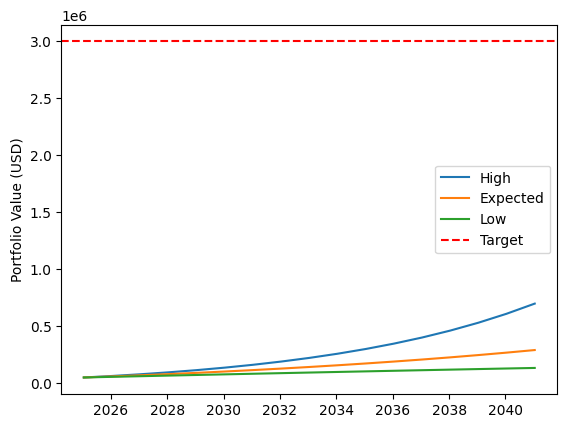

In [ ]:
# Projection
from datetime import date
yearsToGoal = myGoal.targetYear - date.today().year
myProjection = Projection(myPortfolio.expectedReturn,
                          expectedRisk=myPortfolio.expectedRisk,
                          initialInvestment=myGoal.initialContribution,
                          monthlyInvestment=myGoal.monthlyContribution,
                          years=yearsToGoal)
myProjection.visualize(myGoal.targetValue)

In [ ]:
# Check if goal amount is achieved with expectedReturns by goalTimeline
import pandas as pd
def checkGoalPlausible(df: pd.DataFrame, goalValue) -> bool:
  maxValue = df['value'].max()
  if maxValue >= goalValue:
    return True
  else:
    return False

In [ ]:
checkGoalPlausible(myProjection.data, myGoal.targetValue)

False

In [ ]:
import scipy.stats as st
import math as math

minReturn = 0.022
avgReturn = 0.05
avgRisk = 0.07
timeHorizon = 10
std = avgRisk/math.sqrt(timeHorizon)
print(std)

z_score = (minReturn-avgReturn)/std
print(z_score)
print(1-st.norm.cdf(z_score))


0.022135943621178655
-1.264911064067352
0.8970483946339659


In [ ]:
myGoal.getGoalProbabilities()

(0.65, 0.79)

In [ ]:
goalProbabilityForAmount(myGoal.targetValue,
                         myPortfolio.expectedReturn,
                         myPortfolio.expectedRisk,
                         yearsToGoal,
                         myGoal.initialContribution,
                         myGoal.monthlyContribution)

0.0

In [ ]:

def calculateMonthlyMinimum(expectedReturn, initialInvestment, years, goalAmount) -> float:
  monthlyInvestment = (goalAmount - (initialInvestment * pow(1 + expectedReturn/12, (years*12))))/((pow(1 + expectedReturn/12, (years*12))-1)/(expectedReturn/12))
  return monthlyInvestment

In [ ]:
calculateMonthlyMinimum(myPortfolio.expectedReturn,
                        myGoal.initialContribution,
                        yearsToGoal,
                        myGoal.targetValue)

8937.416984611422

In [ ]:
myGoal.monthlyContribution = calculateMonthlyMinimum(myPortfolio.expectedReturn,
                                                     myGoal.initialContribution,
                                                     yearsToGoal,
                                                     myGoal.targetValue)

goalProbabilityForAmount(myGoal.targetValue,
                         myPortfolio.expectedReturn,
                         myPortfolio.expectedRisk,
                         yearsToGoal,
                         myGoal.initialContribution,
                         myGoal.monthlyContribution)

0.49999999998374545

<ipython-input-29-81fd14b276d2>:148: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'date': [newDate], 'lowValue': [newValueLower], 'value': [newValue], 'highValue': [newValueUpper]})])


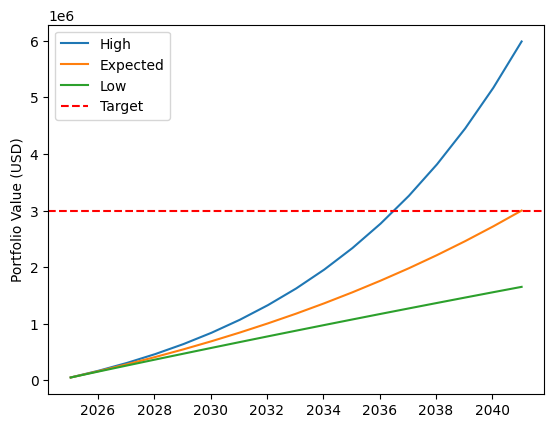

In [ ]:
myProjection = Projection(myPortfolio.expectedReturn,
                          myPortfolio.expectedRisk,
                          myGoal.initialContribution,
                          myGoal.monthlyContribution,
                          yearsToGoal)
myProjection.visualize(myGoal.targetValue)

In [ ]:
goalProbabilityForAmount(myGoal.targetValue,
                         myPortfolio.expectedReturn,
                         myPortfolio.expectedRisk,
                         yearsToGoal+2,
                         myGoal.initialContribution,
                         myGoal.monthlyContribution)

0.8613668759427402

<ipython-input-29-81fd14b276d2>:148: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'date': [newDate], 'lowValue': [newValueLower], 'value': [newValue], 'highValue': [newValueUpper]})])


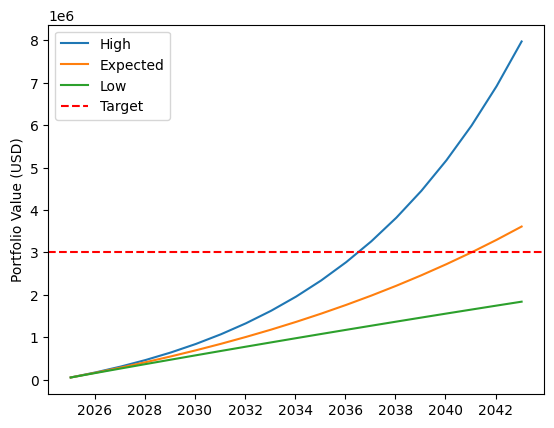

In [ ]:
myProjection = Projection(myPortfolio.expectedReturn,
                          myPortfolio.expectedRisk,
                          myGoal.initialContribution,
                          myGoal.monthlyContribution,
                          yearsToGoal+2)
myProjection.visualize(myGoal.targetValue)